Column:  x1 NAs:  0
Column:  x2 NAs:  0
Column:  x3 NAs:  4
Column:  x4 NAs:  8
Column:  x5 NAs:  4
Column:  x6 NAs:  8
Column:  x7 NAs:  3
Column:  x8 NAs:  2
Column:  x9 NAs:  92
Column:  x10 NAs:  104
Column:  x11 NAs:  1
Column:  x12 NAs:  3
Column:  x13 NAs:  2163
Column:  x14 NAs:  2151
Column:  x15 NAs:  1056
Column:  x16 NAs:  1066
Column:  x17 NAs:  1633
Column:  x18 NAs:  1643
Column:  x19 NAs:  1
Column:  x20 NAs:  0
Column:  x21 NAs:  390
Column:  x22 NAs:  378
Column:  x23 NAs:  422
Column:  x24 NAs:  413
Column:  x25 NAs:  0
Column:  x26 NAs:  0
Column:  x27 NAs:  0
Column:  x28 NAs:  0
Column:  x29 NAs:  0
Column:  x30 NAs:  0
Column:  x31 NAs:  0
Column:  x32 NAs:  0
Column:  x33 NAs:  0
Column:  x34 NAs:  0
Column:  x35 NAs:  0
Column:  x36 NAs:  0
Column:  x37 NAs:  25
Column:  x38 NAs:  0
Column:  x39 NAs:  0
Column:  x40 NAs:  0
Column:  c1 NAs:  0
Column:  c2 NAs:  0
Column:  c3 NAs:  0
Column:  c4 NAs:  0
Column:  c5 NAs:  0
Column:  c6 NAs:  0
Column:  c7 NAs:  0

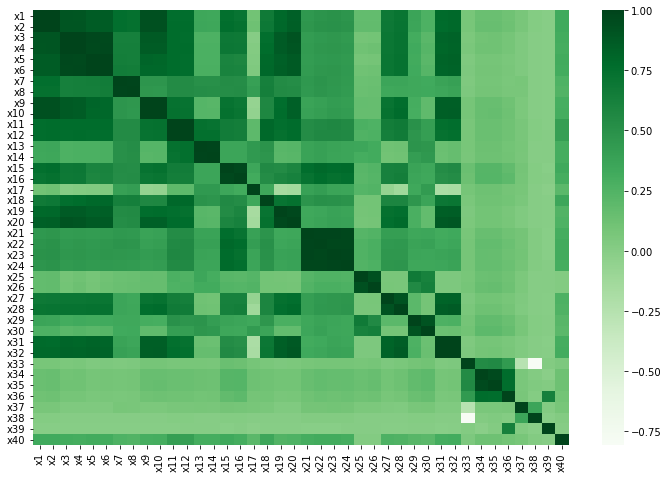

In [20]:
from sklearn.inspection import permutation_importance
import time 

from Script import *

df_train = pd.read_csv("Data/train.csv")
df_test  = pd.read_csv("Data/test.csv")

df_train = df_train.drop("i", axis=1)
y = df_train.pop("y")
df_train.insert(54,"y", y)
df_test = df_test.drop(["y", "i"], axis = 1)

#Changing variable data types
df_test.loc[:, "c1":"c12"] = df_test.loc[:, "c1":"c12"].astype("category")
df_test.loc[:, ["o1", "o2"]] = df_test.loc[:, ["o1", "o2"]].astype("category")
df_train.loc[:, "c1":"c12"] = df_train.loc[:, "c1":"c12"].astype("category")
df_train.loc[:, ["o1", "o2", "y"]] = df_train.loc[:, ["o1", "o2", "y"]].astype("category")

#Call relevant methods until we have results
analyze_dataset(df_train, df_test)
df_train, df_test = preprocess_data(df_train, df_test)



X = df_train.iloc[:, 0:-1]
y = df_train.iloc[:, -1]


In [26]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state = 1)

from pprint import pprint

print('Parameters used:\n')
pprint(rf.get_params())

Parameters used:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}


In [27]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(200, 2000, 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators' : n_estimators,
              'max_features' : max_features,
              'max_depth' :  max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf' : min_samples_leaf,
              'bootstrap' : bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [28]:
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator=rf,
                               param_distributions=random_grid,
                               n_iter=100,
                               cv = 5,
                               verbose=2,
                               random_state=1,
                               n_jobs=-1
                              )

rf_random.fit(X, y)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=1, verbose=2)

In [29]:
rf_random.best_params_

{'n_estimators': 1600,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 70,
 'bootstrap': True}

In [32]:
import joblib
joblib.dump(rf_random,"Temp/rf_random_search.joblib")

['Temp/rf_random_search.joblib']

In [33]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

base_model = RandomForestClassifier(random_state = 1)
base_model.fit(X_train, y_train)
base_acc = np.sum(y_test == base_model.predict(X_test))/len(y_test)
print("base acc", base_acc)

best_random = rf_random.best_estimator_
random_acc = np.sum(y_test == (best_random.predict(X_test)))/len(y_test)

print("random acc", random_acc)


base acc 0.6812339331619537
random acc 0.9477292202227935


In [69]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'bootstrap': [True],
    'max_depth': [60, 70, 80, 90],
    'max_features': ['sqrt'],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [2, 4, 6],
    'n_estimators': [1400, 1600, 1800, 1900]
}


rf = RandomForestClassifier()


grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 3)


In [70]:
grid_search.fit(X, y)
grid_search.best_params_

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[CV 1/5] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=1800;, score=0.682 total time=  33.8s
[CV 3/5] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=1400;, score=0.675 total time=  26.6s
[CV 4/5] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=1600;, score=0.682 total time=  31.1s
[CV 1/5] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=1400;, score=0.681 total time=  29.9s
[CV 4/5] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=1600;, score=0.682 total time=  33.9s
[CV 2/5] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1400;, score=0.686 total time=  25.9s
[CV 4/5] END 

[CV 4/5] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=1600;, score=0.681 total time=  30.6s
[CV 1/5] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=1400;, score=0.695 total time=  26.9s
[CV 5/5] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=1400;, score=0.672 total time=  27.4s
[CV 2/5] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=1900;, score=0.686 total time=  40.3s
[CV 1/5] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=1800;, score=0.678 total time=  37.0s
[CV 3/5] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1400;, score=0.675 total time=  25.8s
[CV 5/5] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_le

[CV 4/5] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=1400;, score=0.685 total time=  27.2s
[CV 2/5] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=1900;, score=0.686 total time=  37.5s
[CV 3/5] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=1800;, score=0.678 total time=  36.6s
[CV 5/5] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=1400;, score=0.671 total time=  30.3s
[CV 5/5] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=1800;, score=0.673 total time=  36.2s
[CV 2/5] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1600;, score=0.686 total time=  29.3s
[CV 4/5] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_le

[CV 2/5] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=1400;, score=0.685 total time=  26.5s
[CV 1/5] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=1900;, score=0.685 total time=  35.5s
[CV 2/5] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=1800;, score=0.688 total time=  36.7s
[CV 4/5] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=1400;, score=0.681 total time=  30.1s
[CV 3/5] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=1800;, score=0.678 total time=  37.1s
[CV 5/5] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1400;, score=0.678 total time=  26.1s
[CV 2/5] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_le

[CV 1/5] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=1600;, score=0.682 total time=  29.1s
[CV 3/5] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=1900;, score=0.677 total time=  35.8s
[CV 4/5] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=1800;, score=0.680 total time=  37.3s
[CV 1/5] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=1600;, score=0.685 total time=  33.4s
[CV 3/5] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=1900;, score=0.675 total time=  37.3s
[CV 5/5] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1600;, score=0.687 total time=  29.7s
[CV 2/5] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_le

[CV 3/5] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=1600;, score=0.676 total time=  30.3s
[CV 5/5] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=1900;, score=0.673 total time=  36.5s
[CV 5/5] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=1800;, score=0.666 total time=  38.3s
[CV 2/5] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=1600;, score=0.688 total time=  34.9s
[CV 5/5] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=1900;, score=0.666 total time=  37.3s
[CV 2/5] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1800;, score=0.686 total time=  32.9s
[CV 4/5] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_le

[CV 2/5] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=1600;, score=0.686 total time=  30.2s
[CV 4/5] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=1900;, score=0.678 total time=  36.9s
[CV 1/5] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=3, min_samples_split=4, n_estimators=1900;, score=0.680 total time=  38.0s
[CV 3/5] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=1600;, score=0.681 total time=  34.2s
[CV 4/5] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=1900;, score=0.682 total time=  37.4s
[CV 1/5] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1800;, score=0.689 total time=  32.6s
[CV 3/5] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_le

{'bootstrap': True,
 'max_depth': 60,
 'max_features': 'sqrt',
 'min_samples_leaf': 5,
 'min_samples_split': 6,
 'n_estimators': 1900}

In [72]:
joblib.dump(grid_search, 'Temp/rf_grid_search.joblib')

['Temp/grid_search.joblib']

In [76]:
model_best_cv =  grid_search.best_estimator_
name_of_model = "rf_grid_search_best"
preds_best_grid = model_best_cv.predict(df_test)

save_predictions(preds_best_grid, "Predictions/"+name_of_model)


In [ ]:


# HERE JUST DO WHATEVER YOU WANT WITH THE MODELS. I DID A STRATIFIED K-FOLD ON A RANDOM FOREST
# COMMENT OR DELETE WHATEVER YOU DON'T WANT TO USE AND MAKE YOUR OWN MODELS TO TEST AND ALL THAT SHIT

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# skf = StratifiedKFold(n_splits = 3)
# score_list = []
# models = []
# #Stratified fold to keep the data imbalance while training
# #Train 3 times to simulate a 3 way cross-validation
# for train, test in skf.split(df_train, y):
#     print('train -  {}   |   test -  {}'.format(np.bincount(y[train]), np.bincount(y[test])))
#     train_x = df_train.iloc[train]
#     train_y = y.iloc[train]
#     test_x = df_train.iloc[test]
#     test_y = y.iloc[test]
#     #CREATE THE MODELS HERE IF POSSIBLE
    
#     #Random Forest
#     clf = RandomForestClassifier(random_state = 0)
#     clf.fit(train_x, train_y)
#     y_pred = clf.predict(test_x)
#     print(compute_metrics(y_pred, test_y))
    
#     #SAVE BEST SCORES AND BEST MODELS TO TEST ON THE DATA LATER.
#     score_list.append(clf.score(test_x,test_y))
#     models.append(clf)

# #Check Metrics attained
# best_model_index = score_list.index(max(score_list))
# preds = models[best_model_index].predict(df_test)


from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

from sklearn.ensemble import GradientBoostingClassifier




clf1 = RandomForestClassifier( random_state=1)

clf2 = make_pipeline(StandardScaler(), SVC(gamma='auto', probability=True))

clf3 = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
    max_depth=1, random_state=0)

print("Fitting Classifiers")
eclf1 = VotingClassifier(estimators=[
        ('rf', clf1), ('svm', clf2), ('xgb', clf3)], voting='hard')



eclf2 = VotingClassifier(estimators=[
        ('rf', clf1), ('svm', clf2), ('xgb', clf3)],
        voting='soft')



print("Hard Voting ")
hard_scores = cross_val_score(eclf1, X, y, cv=10)
print("Soft Voting")
soft_scores = cross_val_score(eclf2, X, y, cv=10)

print("aux stop")


import joblib
name_of_model = "rf+svm+xgboost"

joblib.dump(hard_scores, "Temp/"+name_of_model+"_hard_scores"+".joblib")
joblib.dump(hard_scores, "Temp/"+ name_of_model+"_soft_scores"+ ".joblib")

print("hard voting", hard_scores.mean())
print("soft voting", soft_scores.mean())

print("aux stop")



eclf1.fit(X, y)
preds_hard = eclf1.predict(df_test)
save_predictions(preds_hard, "Predictions/"+name_of_model+"_hard")

eclf2.fit(X, y)
preds_soft = eclf2.predict(df_test)
save_predictions(preds_soft, "Predictions/"+ name_of_model+"_soft")



